Tutorial from: https://www.analyticsvidhya.com/blog/2021/07/stock-market-forecasting-using-time-series-analysis-with-arima-model/

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
stock_data = pd.read_json("../../sample_data/LINKUSDT_1d.json")
stock_data

,open time,open,high,low,close,volume,close time,quote asset volume,number of trades,taker buy base asset volume,taker buy quote asset volume,delete
0,1547596800000,0.5355,0.5355,0.4668,0.4895,1343660.31,1547683199999,6.650136e+05,3492,602419.92,3.001164e+05,0
1,1547683200000,0.4895,0.4953,0.4639,0.4756,1411725.35,1547769599999,6.734472e+05,3987,778386.36,3.708751e+05,0
2,1547769600000,0.4762,0.5112,0.4601,0.4894,984417.59,1547855999999,4.749993e+05,5662,463067.14,2.234760e+05,0
3,1547856000000,0.4908,0.5000,0.4673,0.4831,735443.20,1547942399999,3.540900e+05,4482,335579.52,1.621085e+05,0
4,1547942400000,0.4803,0.4920,0.4590,0.4834,677499.56,1548028799999,3.233336e+05,2098,315527.36,1.507622e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2112,1730073600000,10.9900,11.2700,10.7100,11.1800,2232645.81,1730159999999,2.452865e+07,140222,1067166.98,1.173026e+07,0
2113,1730160000000,11.1900,11.8100,11.1500,11.8000,2413413.41,1730246399999,2.781243e+07,141198,1179830.64,1.359220e+07,0
2114,1730246400000,11.8000,12.4500,11.6500,12.3900,3115047.04,1730332799999,3.767751e+07,179362,1691645.36,2.046836e+07,0
2115,1730332800000,12.4000,12.4700,11.3100,11.4100,2672404.77,1730419199999,3.185358e+07,165377,1260534.45,1.503742e+07,0


In [3]:
stock_data["Date"] = pd.to_datetime(stock_data["open time"],unit='ms')
stock_data.index = stock_data["Date"]
# stock_data.index = pd.DatetimeIndex(stock_data.index).to_period('D')
stock_data

,open time,open,high,low,close,volume,close time,quote asset volume,number of trades,taker buy base asset volume,taker buy quote asset volume,delete,Date
Date,,,,,,,,,,,,,
2019-01-16,1547596800000,0.5355,0.5355,0.4668,0.4895,1343660.31,1547683199999,6.650136e+05,3492,602419.92,3.001164e+05,0,2019-01-16
2019-01-17,1547683200000,0.4895,0.4953,0.4639,0.4756,1411725.35,1547769599999,6.734472e+05,3987,778386.36,3.708751e+05,0,2019-01-17
2019-01-18,1547769600000,0.4762,0.5112,0.4601,0.4894,984417.59,1547855999999,4.749993e+05,5662,463067.14,2.234760e+05,0,2019-01-18
2019-01-19,1547856000000,0.4908,0.5000,0.4673,0.4831,735443.20,1547942399999,3.540900e+05,4482,335579.52,1.621085e+05,0,2019-01-19
2019-01-20,1547942400000,0.4803,0.4920,0.4590,0.4834,677499.56,1548028799999,3.233336e+05,2098,315527.36,1.507622e+05,0,2019-01-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-28,1730073600000,10.9900,11.2700,10.7100,11.1800,2232645.81,1730159999999,2.452865e+07,140222,1067166.98,1.173026e+07,0,2024-10-28
2024-10-29,1730160000000,11.1900,11.8100,11.1500,11.8000,2413413.41,1730246399999,2.781243e+07,141198,1179830.64,1.359220e+07,0,2024-10-29
2024-10-30,1730246400000,11.8000,12.4500,11.6500,12.3900,3115047.04,1730332799999,3.767751e+07,179362,1691645.36,2.046836e+07,0,2024-10-30


In [4]:
stock_data.drop(columns=['open time', 'close time', 'delete', 'Date'], inplace=True)
stock_data

,open,high,low,close,volume,quote asset volume,number of trades,taker buy base asset volume,taker buy quote asset volume
Date,,,,,,,,,
2019-01-16,0.5355,0.5355,0.4668,0.4895,1343660.31,6.650136e+05,3492,602419.92,3.001164e+05
2019-01-17,0.4895,0.4953,0.4639,0.4756,1411725.35,6.734472e+05,3987,778386.36,3.708751e+05
2019-01-18,0.4762,0.5112,0.4601,0.4894,984417.59,4.749993e+05,5662,463067.14,2.234760e+05
2019-01-19,0.4908,0.5000,0.4673,0.4831,735443.20,3.540900e+05,4482,335579.52,1.621085e+05
2019-01-20,0.4803,0.4920,0.4590,0.4834,677499.56,3.233336e+05,2098,315527.36,1.507622e+05
...,...,...,...,...,...,...,...,...,...
2024-10-28,10.9900,11.2700,10.7100,11.1800,2232645.81,2.452865e+07,140222,1067166.98,1.173026e+07
2024-10-29,11.1900,11.8100,11.1500,11.8000,2413413.41,2.781243e+07,141198,1179830.64,1.359220e+07
2024-10-30,11.8000,12.4500,11.6500,12.3900,3115047.04,3.767751e+07,179362,1691645.36,2.046836e+07


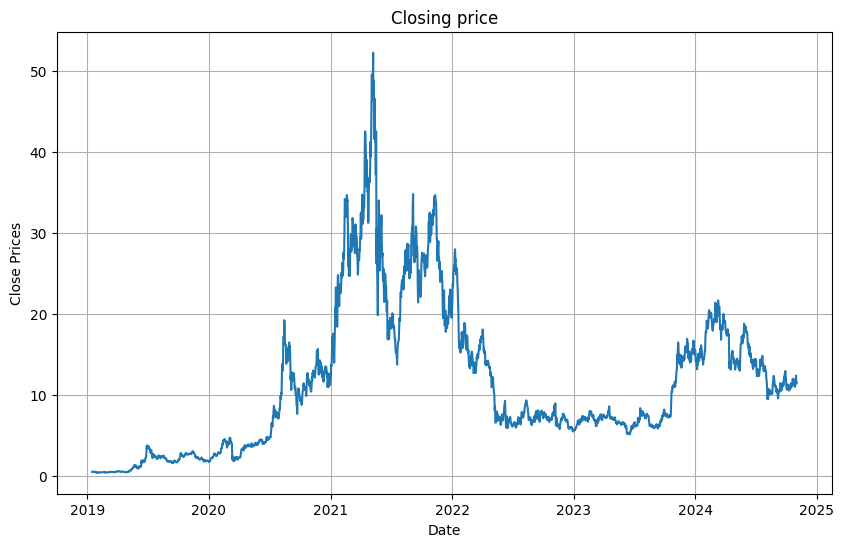

In [5]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['close'])
plt.title('Closing price')
plt.show()

<Axes: ylabel='Density'>

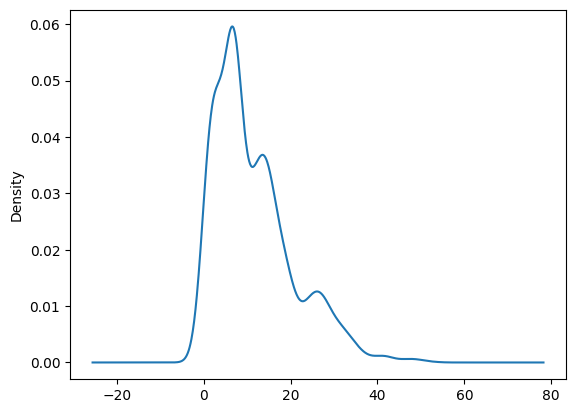

In [6]:
#Distribution of the dataset
df_close = stock_data['close']
df_close.plot(kind='kde')


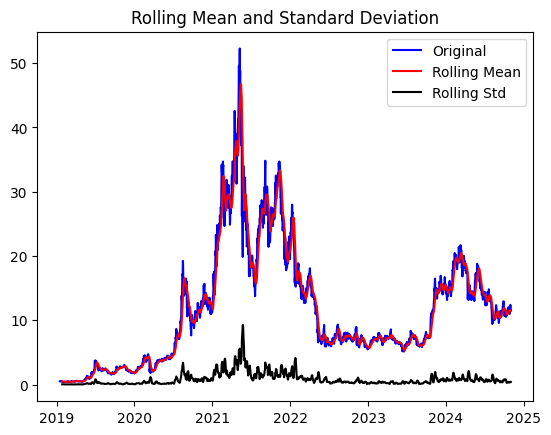

Results of dickey fuller test
Test Statistics                  -2.170239
p-value                           0.217224
No. of lags used                 25.000000
Number of observations used    2091.000000
critical value (1%)              -3.433481
critical value (5%)              -2.862923
critical value (10%)             -2.567506
dtype: float64


In [7]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

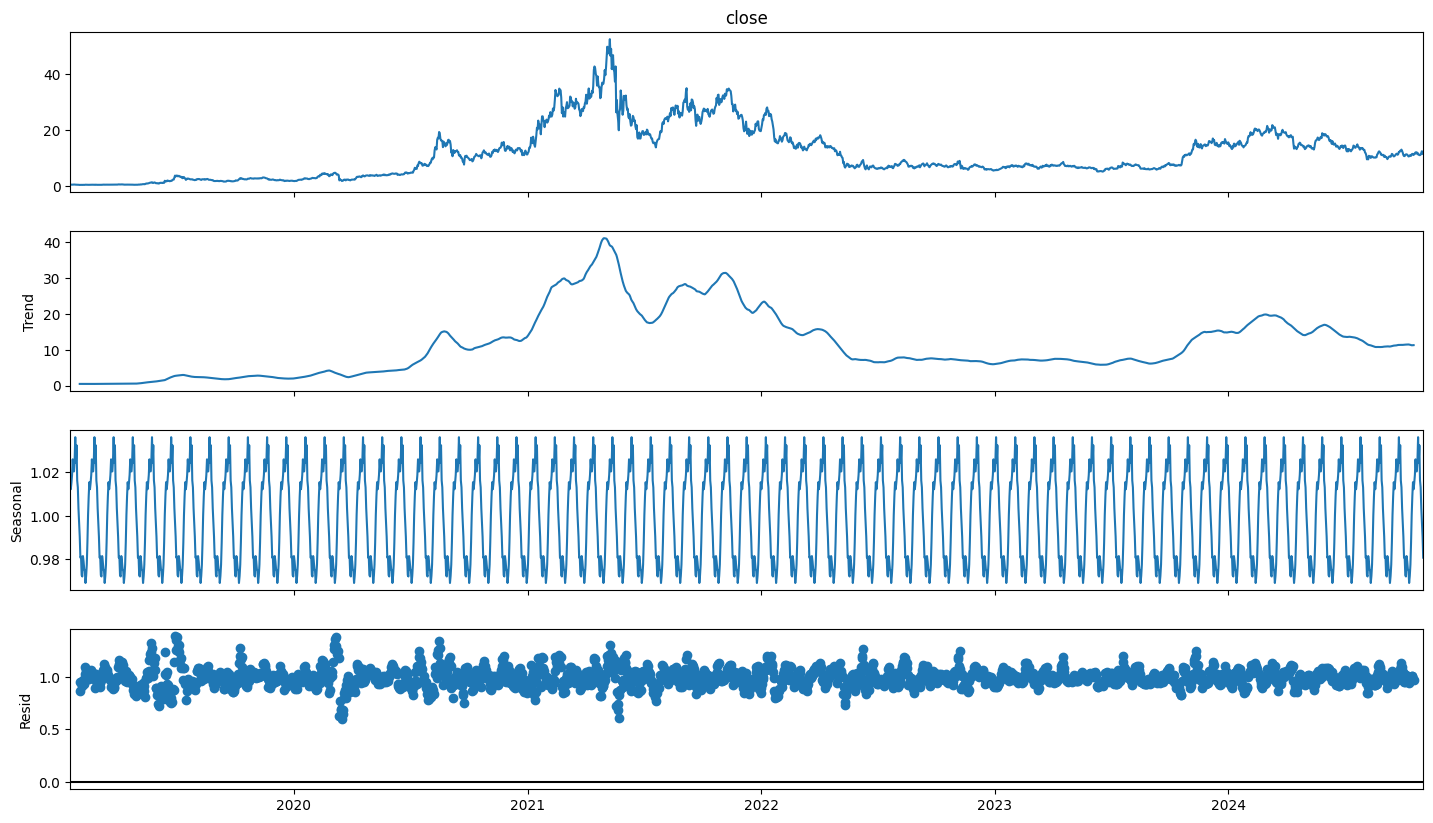

In [8]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

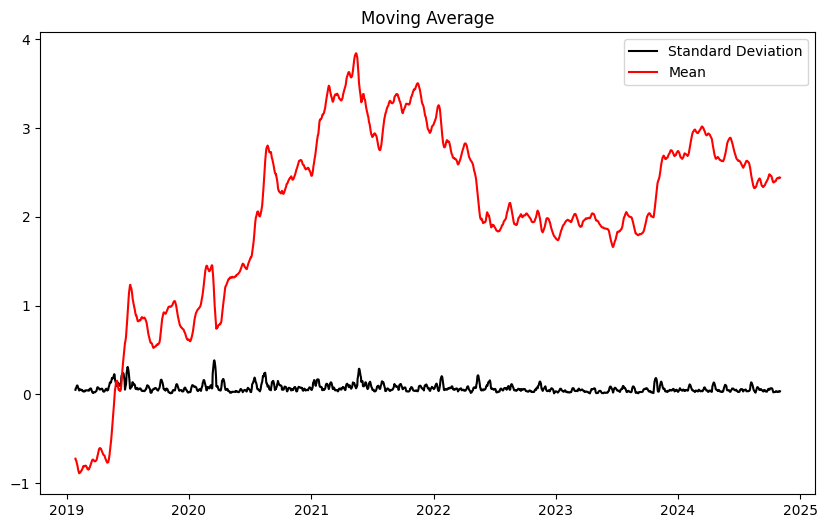

In [9]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

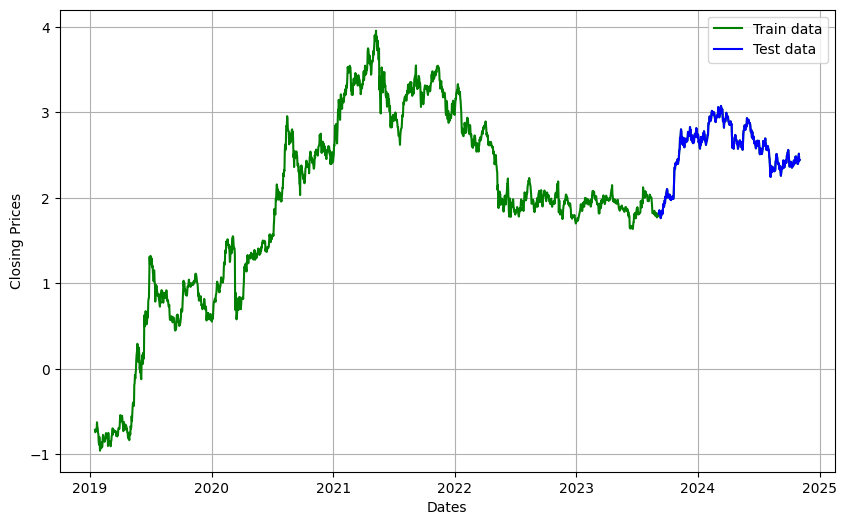

In [10]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4564.839, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4578.243, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4577.511, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4565.878, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4576.803, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4576.658, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4576.435, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4579.080, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4577.682, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4577.523, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4578.340, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4575.759, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.098 seconds
                               SARIMAX Results                              

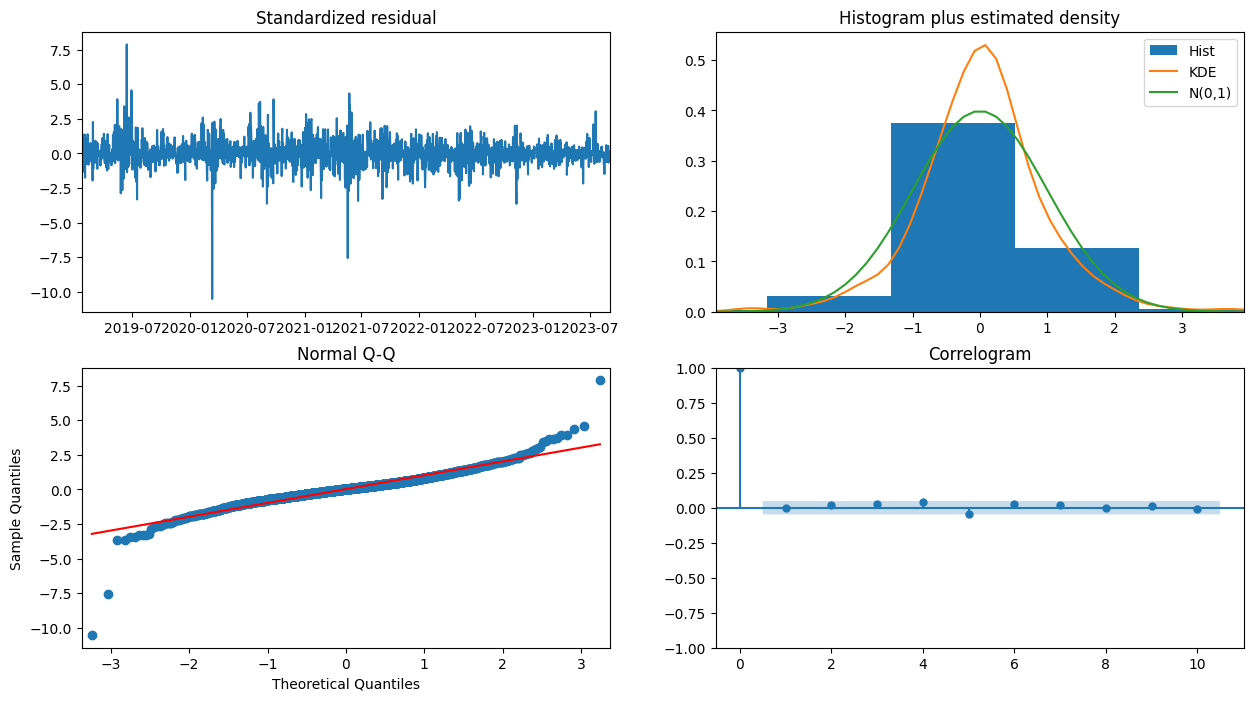

In [11]:
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='kpss',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal='ocsb',   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [12]:
#As a result, the Auto ARIMA model assigned the values 1, 1, and 0 to, p, d, and q, respectively.

#Modeling
# Build Model
model = ARIMA(train_data, freq = 'D', order=(1,1,0))  

fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1690
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2291.540
Date:                Wed, 04 Dec 2024   AIC                          -4579.080
Time:                        19:21:50   BIC                          -4568.216
Sample:                    01-19-2019   HQIC                         -4575.056
                         - 09-04-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0947      0.017     -5.485      0.000      -0.129      -0.061
sigma2         0.0039   4.98e-05     78.011      0.000       0.004       0.004
Ljung-Box (L1) (Q):                   0.00   Jarque-

/Users/andyisworking/Documents/DataEngineeringBootcamp_DataScientest/crypto_bot/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


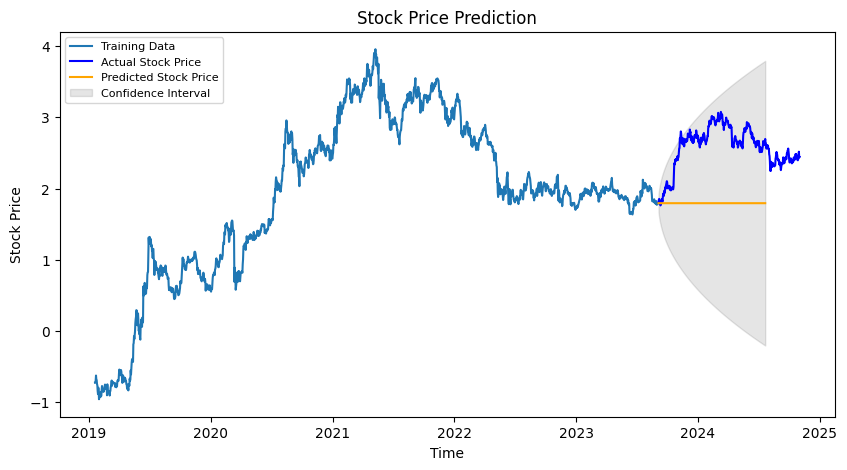

In [13]:
# Generate forecast and confidence intervals
pred = fitted.get_forecast(steps=321, alpha=0.05)

# Extract forecast and confidence intervals
fc_series = pd.Series(pred.predicted_mean, index=test_data.index)
conf = pred.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10, label='Confidence Interval')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [14]:
# Ensure forecast length matches test_data
forecast_steps = len(test_data)
pred = fitted.get_forecast(steps=forecast_steps)

# Extract forecast and align indices
fc = pred.predicted_mean
fc = fc.iloc[:len(test_data)]  # Trim forecast if it exceeds test_data length

# Performance metrics
mse = mean_squared_error(test_data, fc)
print('MSE: ' + str(mse))

mae = mean_absolute_error(test_data, fc)
print('MAE: ' + str(mae))

rmse = math.sqrt(mse)
print('RMSE: ' + str(rmse))

mape = np.mean(np.abs(fc - test_data) / np.abs(test_data))
print('MAPE: ' + str(mape))


MSE: 0.6968128000971066
MAE: 0.782131428940764
RMSE: 0.8347531372190862
MAPE: 0.29341882530050506
